# Klasifikace zvukových záznamů 
## Vypracovali Marek Tremel, Radek Novák a Kseniia Mahalias

**Zadání**: Ve zdrojové databázi najdete celkem 208 hlasových záznamů písmene a. Pomocí Vámi vybrané
techniky v časové nebo frekvenční oblasti klasifikujte zvukové záznamy na dobré a patologické.
V případě patologických poté klasifikujte jednotlivé poruchy. Jejich výčet najdete buď
v hlavičkových souborech nebo v propisu databáze. Pro klasifikaci do jednotlivých skupin
použijte veškeré techniky, které jste si v rámci kurzu osvojili včetně Fourierovy a kepstrální
analýzy. Úspěšnost Vašeho postupu porovnejte s anotacemi, resp. rozřazením do skupin, které
provedli experti, kteří data pořizovali.

----------


## Použité knihovny

In [6]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import re
import librosa.display
import seaborn as sns

## Funkce: parse_diagnosis(info_file_path)

Tato funkce načítá diagnostickou informaci ze souboru -info.txt, který obsahuje textové informace o diagnóze.

In [7]:
def parse_diagnosis(info_file_path):
    """
    Parsuje diagnostickou informaci z textového souboru.

    Parametry:
    info_file_path : str
        Cesta k souboru obsahujícímu informace o diagnóze.

    Návratová hodnota:
    str : Diagnóza jako řetězec, pokud byla nalezena, jinak None.
    """
    with open(info_file_path, "r") as f:  # Otevření souboru pro čtení
        content = f.read()  # Načtení obsahu souboru

        # Hledání řádku obsahujícího "Diagnosis: " a následně diagnostický text
        diagnosis_match = re.search(r"Diagnosis:\s+(.+)", content)

        if diagnosis_match:
            return diagnosis_match.group(
                1
            ).strip()  # Vrácení extrahované diagnózy bez mezer

    return None  # Pokud diagnóza nebyla nalezena, vrátí None

## Výpočet energie signálu
`signal**2`: Toto umocní každý vzorek signálu na druhou, což je způsob výpočtu energie.

`np.mean(signal**2)`: Průměruje druhé mocniny vzorků, čímž získáme průměrnou energii signálu.

`np.abs()`: Přidání absolutní hodnoty je zde ochranný krok.


## Výpočet jitter
U hlasové analýzy jitter popisuje nepravidelnosti v periodě hlasových kmitů (například kolísání frekvence hlasu). 

`np.sign(signal)` : Tato funkce převádí signál na jeho znamení:
- Pozitivní hodnoty - 1
- Negativní hodnoty - -1
- Nuly - 0

`p.diff()`: počítá rozdíly mezi sousedními prvky. 

`np.where(...)[0]`:  vrátí indexy, kde došlo ke změně znaménka (tedy k průchodu nulou).




In [8]:

# Funkce pro výpočet energie signálu
def compute_energy(signal):
    return np.abs(np.mean(signal**2))


# Funkce pro výpočet jitteru
def compute_jitter(signal, fs):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    return len(zero_crossings) / len(signal)


## Načítání a zpracování hlasových souborů

1. Definování cesty k datům
2. Načtení seznamu souborů
3. Inicializace seznamů pro výsledky
4. Hlavní smyčka pro zpracování souborů
    - Vzorkovací frekvenci jsem zadal 8000 podle printů jednotlivých signálů.
    - Energie pomocí `compute_energy`.
    - Jitter pomocí `compute_jitter`.
    - MFCC (Mel-Frequency Cepstral Coefficients) a jejich variabilitu pomocí `librosa.feature.mfcc` a` np.std`.
    

In [17]:
# Cesta k adresáři se soubory hlasových záznamů
data_dir = "../data/voices"

# Seznam všech souborů v adresáři
dat_files = [f for f in os.listdir(data_dir) if f.endswith(".dat")]

# Seznam pro uložení výsledků
results = []
mfcc_variabilities = []  # Sbíráme hodnoty pro výpočet průměru

for dat_file in dat_files:
    file_path = os.path.join(data_dir, dat_file)
    info_file_path = os.path.join(data_dir, dat_file.replace(".dat", "-info.txt"))

    try:
        # Načtení signálu jako binárního souboru
        signal = np.fromfile(file_path, dtype=np.int16)
        fs = 8000  # vzorkovací frekvenci 8000 Hz podle načtených dat

        # Výpočet příznaků
        energy = compute_energy(signal)
        jitter = compute_jitter(signal, fs)
        mfccs = librosa.feature.mfcc(y=signal.astype(float), sr=fs, n_mfcc=13)
        mfcc_variability = np.std(mfccs)

        # Uložení hodnoty MFCC variability pro analýzu
        mfcc_variabilities.append(mfcc_variability)

        real_diagnosis = parse_diagnosis(info_file_path)

        results.append([dat_file, energy, jitter, mfcc_variability, real_diagnosis])

    except Exception as e:
        print(f"❌ Chyba při načítání {dat_file}: {e}")
        continue

##  Uložení do datasetu a csv, globální vyhodnocení a klasifikace do *dobrý* a *patologický*

1. Uložení do pandas datasetu
2. Vypoteční globálních výsledku pro printy
3. Klasifikace hlasových záznamů 
- Funkce `classify_voice` slouží k automatické klasifikaci hlasových záznamů na základě tří hlavních příznaků (features):
    - Energie hlasu 
    - Jitter (Frekvenční nepravidelnost)
    - Variabilita MFCC (Mel-frekvenční cepstrální koeficienty)
4. Uložení do csv

In [20]:
# Analýza datasetu Výpočet průměrné MFCC variability a odchylky
df = pd.DataFrame(
    results,
    columns=["Filename", "Energy", "Jitter", "MFCC Variability", "Real Diagnosis"],
)
mean_mfcc = df["MFCC Variability"].mean()
std_mfcc = df["MFCC Variability"].std()

# Nové hranice na základě percentilů datasetu
energy_threshold = df["Energy"].mean()  # Průměrná hodnota energie
jitter_threshold = df["Jitter"].mean()  # Průměrná hodnota jitteru
mfcc_threshold = mean_mfcc + (std_mfcc * 0.8)  # Přísnější MFCC limit

print(f"📊 Průměrná MFCC variabilita: {mean_mfcc:.2f}")
print(f"📊 Směrodatná odchylka MFCC: {std_mfcc:.2f}")
print(f"📊 Energy threshold: {energy_threshold:.3f}")
print(f"📊 Jitter threshold: {jitter_threshold:.3f}")
print(f"📊 MFCC threshold: {mfcc_threshold:.3f}")


# Klasiﬁkace hlasových záznamů
def classify_voice(energy, jitter, mfcc_variability):
    if (
        energy < energy_threshold
        or jitter > jitter_threshold
        or mfcc_variability > mfcc_threshold
    ):
        return "Patologický"
    else:
        return "Dobrý"


df["Classification"] = df.apply(
    lambda row: classify_voice(row["Energy"], row["Jitter"], row["MFCC Variability"]),
    axis=1,
)

# **Uložení výsledků do CSV**
df.to_csv("classification_results.csv", index=False)
print("✅ Výsledky klasifikace byly uloženy do classification_results.csv")

📊 Průměrná MFCC variabilita: 316.65
📊 Směrodatná odchylka MFCC: 0.85
📊 Energy threshold: 350.951
📊 Jitter threshold: 0.505
📊 MFCC threshold: 317.334
✅ Výsledky klasifikace byly uloženy do classification_results.csv


## Vizualizace
Pro první tři signály jsou vytvořeny grafy:
1. Časový průběh: Vykreslen pomocí plt.plot.
2. Spektrogram: Vytvořen pomocí librosa.stft a zobrazen s librosa.display.specshow.

### Vizualizace distribuce klasifikace
Pomocí `seaborn.countplot` je vytvořen graf zobrazující distribuci signálů podle klasifikace


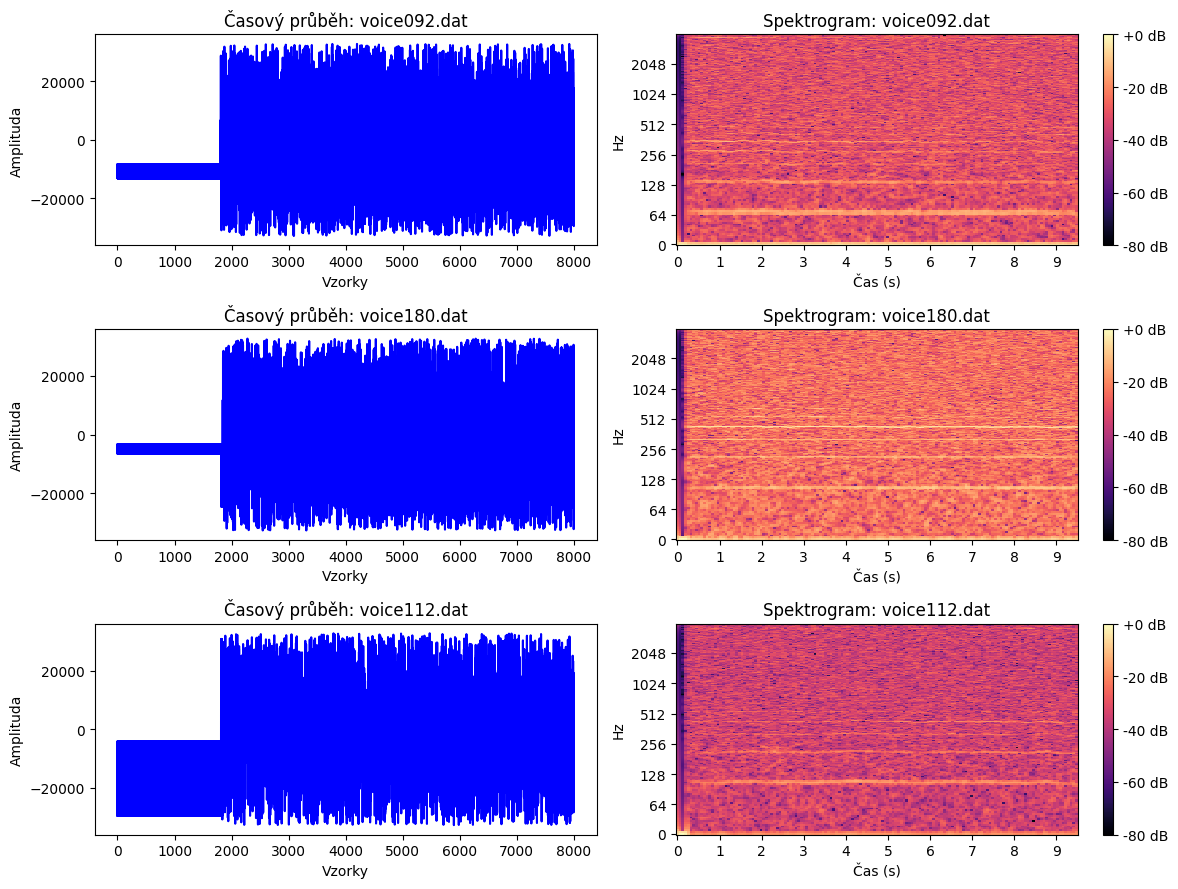

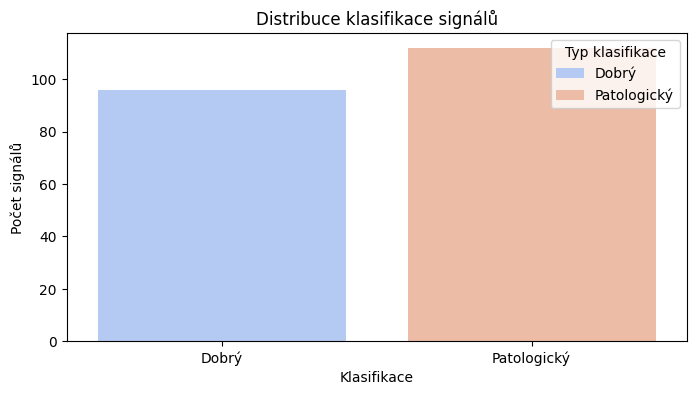

In [19]:
# Vybereme první tři řádky pro vizualizaci
samples_to_plot = df.head(3)

fig, axes = plt.subplots(3, 2, figsize=(12, 9))

for i, row in enumerate(samples_to_plot.itertuples(), 0):
    file_path = os.path.join(data_dir, row.Filename)
    signal = np.fromfile(file_path, dtype=np.int16)

    # Časový průběh signálu
    axes[i, 0].plot(signal[:8000], color="blue")
    axes[i, 0].set_title(f"Časový průběh: {row.Filename}")
    axes[i, 0].set_xlabel("Vzorky")
    axes[i, 0].set_ylabel("Amplituda")

    # Spektrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(signal.astype(float))), ref=np.max)
    img = librosa.display.specshow(
        D, sr=8000, x_axis="time", y_axis="log", ax=axes[i, 1]
    )
    axes[i, 1].set_title(f"Spektrogram: {row.Filename}")
    axes[i, 1].set_xlabel("Čas (s)")

    # Přidání barevné škály ke spektrogramu
    fig.colorbar(img, ax=axes[i, 1], format="%+2.0f dB")

plt.tight_layout()
plt.show()

# Vizualizace distribuce klasifikace
plt.figure(figsize=(8, 4))
sns.countplot(x="Classification", hue="Classification", data=df, palette="coolwarm", legend=True)
plt.title("Distribuce klasifikace signálů")
plt.xlabel("Klasifikace")
plt.ylabel("Počet signálů")
plt.legend(title="Typ klasifikace")
plt.show()

## Slovní ohodnocení

Zpracovali jsme postupně 208 hlasových záznamu, které jsme jednotlivě klasifikovali jako dobrý nebo patologický.  Pro zpracování jsme aplikovali metordy jako je Fourierova a kepstrální analýza.
Výsledek obsahoval enrgii signálu, jitter (nepravidelnosti) a variabilitu MFCC (Mel-frekvenční cepstrální koeficienty).
Klasifikace byla provedena na základě průměrných hodnot těchto příznaků a výsledky byly porovnány s expertními anotacemi.

V tomto projektu jsem si znázornil, jak pracovat s  Fourierovou, kepstrální analýza. Tyto metody analýzy by mi pomohly v hlubší práce se signály.

Zároveň jsme nenarazili na úspěšnou implementaci rozklasifikování patologických hlasů. Při zkoumání možných návazností jsme nenašli dostatečné souvislosti. Existují však různé metody strojového učení, které by mohly být relevantní, ale nebyly v rámci tohoto kurzu zmíněny, například 
[VoicePathology](https://github.com/tynski/VoicePathology)


[Energie signálu](https://cs.wikipedia.org/wiki/Energie_(zpracov%C3%A1n%C3%AD_sign%C3%A1lu))

[Jitter](https://cs.wikipedia.org/wiki/Jitter)

[MFCC](https://stackoverflow.com/questions/60492462/mfcc-python-completely-different-result-from-librosa-vs-python-speech-features)

[MFCC Wiki](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)